## Analysis of the Model Approach to Customer Lifetime Value Prediction

CLV merupakan score yang mendeskripsikan value customer bagi revenue perusahaan. <br>
Tinggi rendahnya score pada tiap customer diperoleh berdasarkan seberapa lama/sering customer menjalin hubungan dengan perusahaan, serta seberapa besar nilai masukan ataupun cost yang dihasilkan oleh customer bagi perusahaan.<br>
Mengetahui CLV score dapat membantu perusahaan dalam budgeting & financial planning, penerapan business & marketing strategy pada tiap jenis customer ataupun secara personalized nantinya.<br>
Oleh karena itu, **perusahaan memerlukan sistem yang bisa melakukan prediksi CLV score dengan minimum error sekecil mungkin agar perusahaan bisa mendapatkan gambaran (expected future) yang bisa dimanfaatkan untuk mengetahui potentially profitable customer, produk yang sedang diminati customer serta strategi yang tepat untuk meningkatkan retensi customer terhadap perusahaan.**


In [26]:
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')


**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| Vehicle Class | Object | Type of vehicle class |
| Coverage | Object | Type of vehicle insurance |
| Renew Offer Type | Object | Type of insurance renewal offer |
| EmployementStatus | Object | Current status of customer in professional term |
| MaritalStatus | Object | Current status of customer in relationship term |
| Education | Object | Education |
| Number of Policies | Float | Number of insurance policies that customer holds |
| Monthly Premium Auto | Float | Amount the policyholder pays monthly for their auto insurance* coverage |
| Total Claim Amount | Float | Total amount of money the insurance company has paid out in claims. |
| Income | Float | Annual** income of customer |
| Customer Lifetime Value | Float | Metric that estimates the total revenue a company can expect from a customer |

*Auto Insurance Policy is an insurance that covers damages or losses to the policyholder's vehicle <br>
**Consider it as it is

In [2]:
df = pd.read_csv(r'C:\Clarenti\Data\Project\Py\Analytics\DS/3/dataset_kelompok/data_customer_lifetime_value.csv')
df.head()

Vehicle Class  Coverage Renew Offer Type EmploymentStatus Marital Status  \
0  Four-Door Car  Extended           Offer1          Retired       Divorced   
1  Four-Door Car     Basic           Offer1         Employed        Married   
2   Two-Door Car     Basic           Offer1          Retired        Married   
3  Four-Door Car   Premium           Offer3         Disabled        Married   
4   Two-Door Car     Basic           Offer3    Medical Leave        Married   

              Education  Number of Policies  Monthly Premium Auto  \
0  High School or Below                 2.0                  90.0   
1               College                 6.0                  62.0   
2                Master                 2.0                  62.0   
3  High School or Below                 1.0                 116.0   
4  High School or Below                 1.0                  62.0   

   Total Claim Amount   Income  Customer Lifetime Value  
0          571.479602  11828.0             10083.486880  
1          114.514440  44762.0              4943.386117  
2          257.248789  21514.0             11981.984810  
3          556.800000  17913.0              4550.856045  
4          355.820799  19030.0              2372.155492

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Vehicle Class            5669 non-null   object 
 1   Coverage                 5669 non-null   object 
 2   Renew Offer Type         5669 non-null   object 
 3   EmploymentStatus         5669 non-null   object 
 4   Marital Status           5669 non-null   object 
 5   Education                5669 non-null   object 
 6   Number of Policies       5669 non-null   float64
 7   Monthly Premium Auto     5669 non-null   float64
 8   Total Claim Amount       5669 non-null   float64
 9   Income                   5669 non-null   float64
 10  Customer Lifetime Value  5669 non-null   float64
dtypes: float64(5), object(6)
memory usage: 487.3+ KB


In [59]:
df.isna().sum()

Vehicle Class              0
Coverage                   0
Renew Offer Type           0
EmploymentStatus           0
Marital Status             0
Education                  0
Number of Policies         0
Monthly Premium Auto       0
Total Claim Amount         0
Income                     0
Customer Lifetime Value    0
dtype: int64

In [60]:
df.plot(kind='box', figsize=(10,3))

<Axes: >

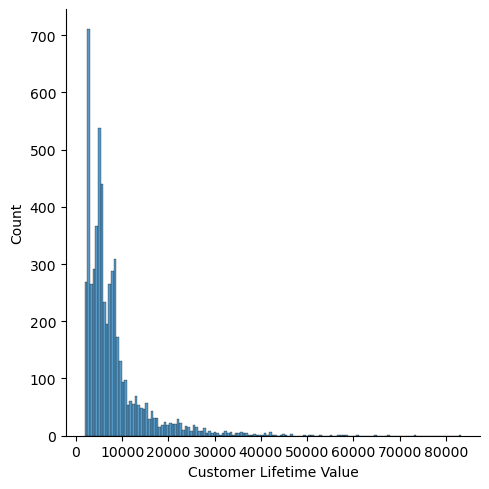

In [61]:
sns.displot(df['Customer Lifetime Value'])

In [4]:
df['Customer Lifetime Value'].median()

5800.188903

<Axes: >

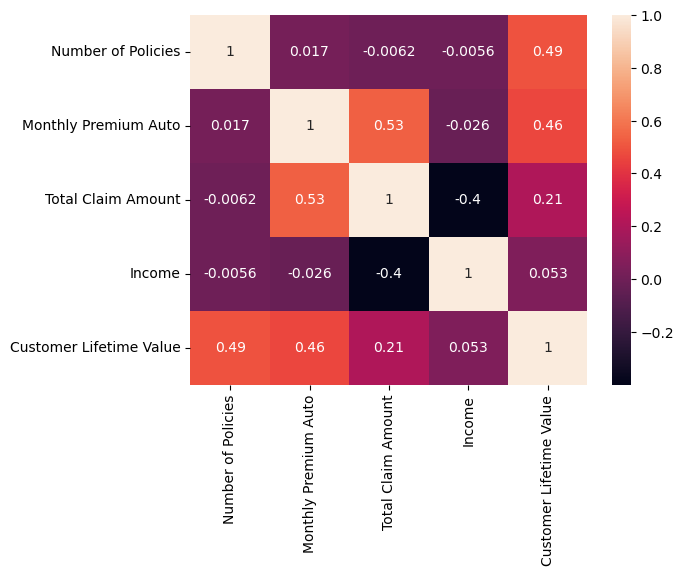

In [62]:
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True)

- CLV memiliki moderate korelasi pada number of policies (kecenderungan semakin besar nilai clv, jumlah policy dan monthly premium semakin besar)
- Korelasi searah antara CLV dan Total Claim, indikasi semakin besar total claim amount semakin besar nilai clv, namun korelasi ini termasuk korelasi lemah dengan strength 20%

- Income dan Total Claim Amount memiliki moderate / korelasi sedang yang berlawanan, menjelaskan semakin besar income, nilai clv cenderung menurun.

- Total Claim Amount and Monthly Premium Auto memiliki relasi positif cukup kuat. (semakin besar value monthly premium auto semakin besar total claim).

*notes: CLV memiliki korelasi terhadap 3 fitur numerical (number of policies, total claim amount, dan monthly premium), dimana tiap fitur memiliki korelasi dengan fitur lainnya.

*Diperlukan pengecekan MultiCollinearity

In [63]:
df.describe()

Number of Policies  Monthly Premium Auto  Total Claim Amount  \
count         5669.000000           5669.000000         5669.000000   
mean             2.979361             93.026989          431.407103   
std              2.393187             34.551795          287.558038   
min              1.000000             61.000000            0.423310   
25%              1.000000             68.000000          266.932542   
50%              2.000000             82.000000          379.200000   
75%              4.000000            109.000000          549.986128   
max              9.000000            297.000000         2759.794354   

             Income  Customer Lifetime Value  
count   5669.000000              5669.000000  
mean   37868.188569              8029.874592  
std    30490.490723              6916.708246  
min        0.000000              1898.007675  
25%        0.000000              3954.344534  
50%    34322.000000              5800.188903  
75%    62464.000000              9031.214859  
max    99934.000000             83325.381190

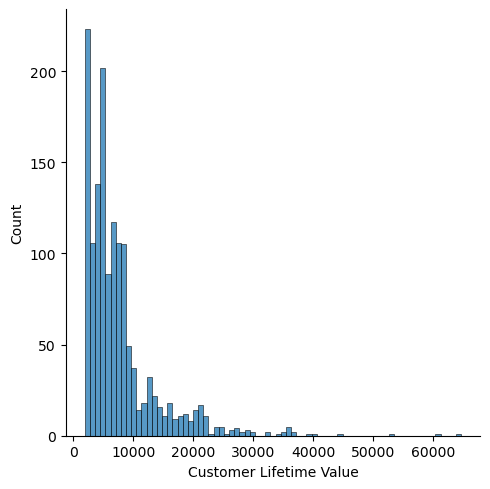

In [67]:
sns.displot(df[(df.Income == 0)]['Customer Lifetime Value'])

In [68]:
df[(df.Income == 0)]['Customer Lifetime Value'].median()

5714.246379

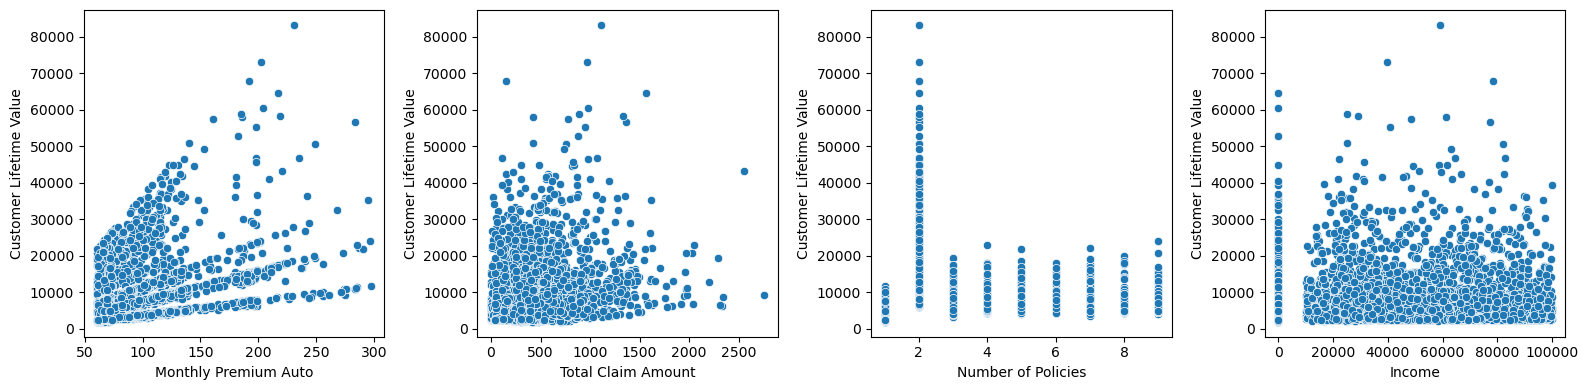

In [69]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
sns.scatterplot(ax=ax[0], data = df, y='Customer Lifetime Value', x='Monthly Premium Auto')
sns.scatterplot(ax=ax[1], data = df, y='Customer Lifetime Value', x='Total Claim Amount')
sns.scatterplot(ax=ax[2], data = df, y='Customer Lifetime Value', x='Number of Policies')
sns.scatterplot(ax=ax[3], data = df, y='Customer Lifetime Value', x='Income')
plt.tight_layout();

- CLV & Monthly Premium memiliki hubungan linear, indikasi setiap kenaikan value pada "Monthly Premium" maka kenaikan juga pada CLV Score.

##### Correlation CLV Score & Categorical Variables 

In [70]:
lists = []
for i in df.select_dtypes('object').columns:
    lists.append([i, df[i].nunique(), df[i].unique()])

pd.DataFrame(lists, columns=['column', 'nunique', 'unique'])

column  nunique  \
0     Vehicle Class        6   
1          Coverage        3   
2  Renew Offer Type        4   
3  EmploymentStatus        5   
4    Marital Status        3   
5         Education        5   

                                                                   unique  
0  [Four-Door Car, Two-Door Car, SUV, Sports Car, Luxury SUV, Luxury Car]  
1                                              [Extended, Basic, Premium]  
2                                        [Offer1, Offer3, Offer2, Offer4]  
3                [Retired, Employed, Disabled, Medical Leave, Unemployed]  
4                                             [Divorced, Married, Single]  
5               [High School or Below, College, Master, Bachelor, Doctor]

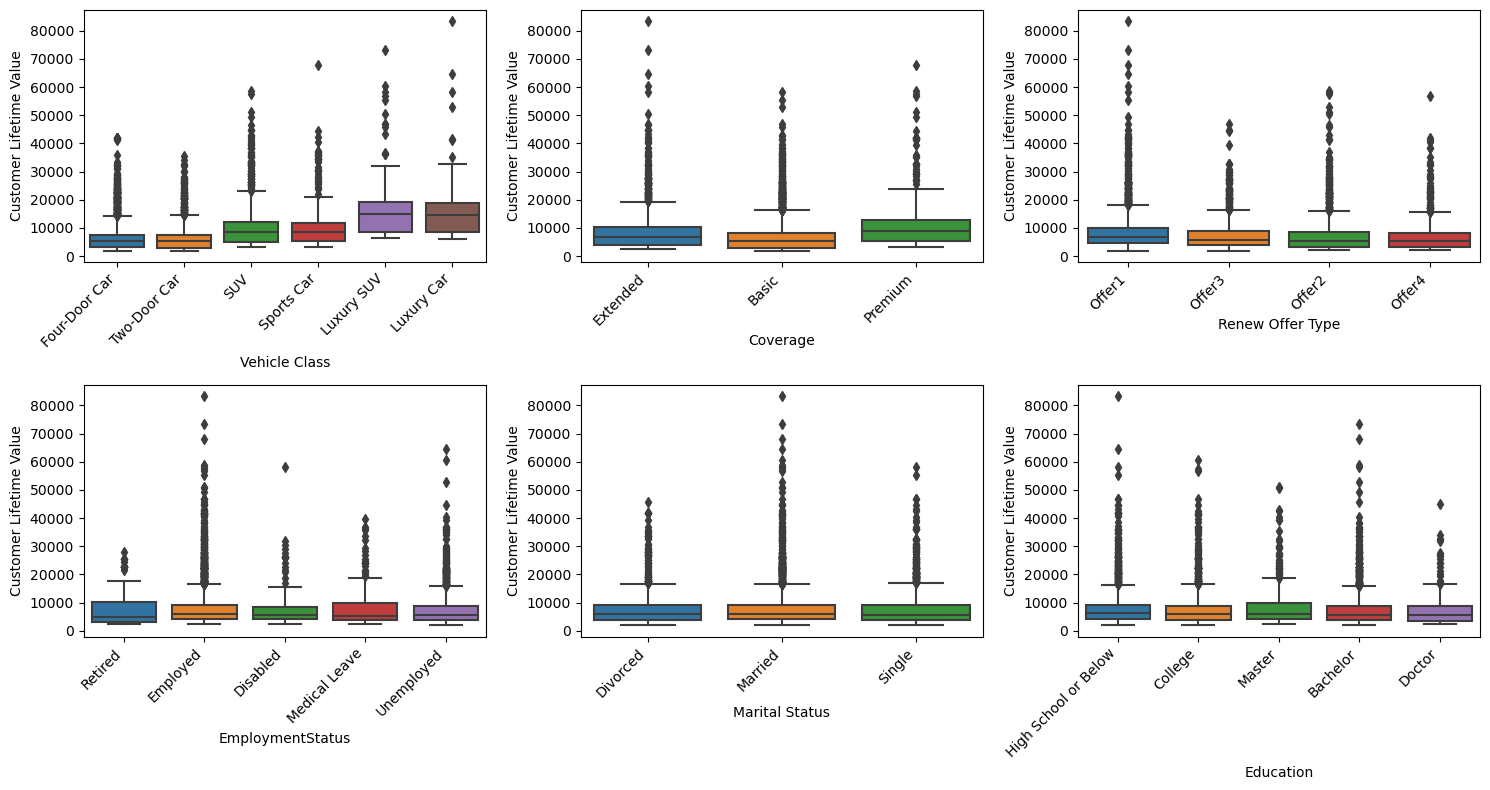

In [71]:
max_column = 3
max_row = 2
j,k = 0,0

fig, ax = plt.subplots(max_row,max_column, figsize=(15, 8))
for i in df.select_dtypes('object').columns:
    if k == max_column:
        j += 1
        k=0
        
    axes = sns.boxplot(ax=ax[j, k],data = df, x=i, y='Customer Lifetime Value')
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    k += 1

plt.tight_layout();

Features correlated with CLV:
- Employment Status : status customer mempengaruhi besar kecil score clv.
- Marital Status : status married mempengaruhi behaviour customer yang berdampak pada clv score.
- Education : Customer dengan tingkat pendidikan tinggi, kecenderungan melakukan repeat order product rendah yang berdampak pada clv score customer. 
- Vehicle Class: Customer yang melakukan pembelian kendaraan dengan kelas tinggi, kecenderungan memiliki score clv besar*
- Coverage & Renew Offer Type: Pemilihan jenis coverage dan tipe renewal mempengaruhi customer dalam melakukan repeat order**

*hal ini bisa dipengaruhi baik dari behaviour maupun kemampuan customer <Br>
**berdampak pada clv score 

In [5]:
df[ (df.Income == 0) & (df.EmploymentStatus != 'Unemployed') ]

Empty DataFrame
Columns: [Vehicle Class, Coverage, Renew Offer Type, EmploymentStatus, Marital Status, Education, Number of Policies, Monthly Premium Auto, Total Claim Amount, Income, Customer Lifetime Value]
Index: []

In [6]:
len(df[ (df.Income > 0) & (df.EmploymentStatus == 'Unemployed') ])

0

In [7]:
df[(df.Income == 0)]['EmploymentStatus'].unique()

array(['Unemployed'], dtype=object)

- Data menjelaskan customer dengan status unemployed tidak memiliki income 

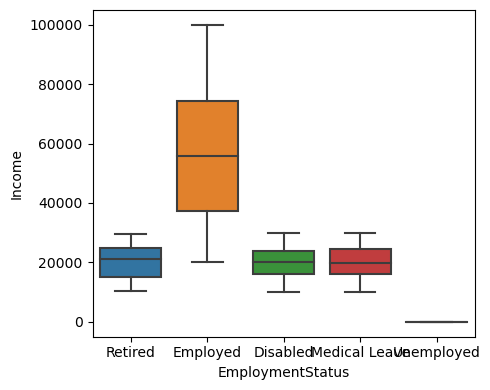

In [95]:
plt.figure(figsize=(5,4))
sns.boxplot(x=df['EmploymentStatus'], y=df['Income'])
plt.tight_layout();

- Income sangat berpengaruh terhadap status Employed dan Unemployed*

*diperlukan pengecekan MultiCollinearity

##### Feature Engineer

In [3]:
categorical_features = ['EmploymentStatus', 'Marital Status', 'Renew Offer Type']
ordinal_features = ['Vehicle Class', 'Coverage', 'Education']

categorical_tf = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')),
    ]
)

# Define order
vehicle_class_order = ['Four-Door Car', 'Two-Door Car', 'SUV', 'Luxury SUV', 'Sports Car', 'Luxury Car']
coverage_order = ['Basic', 'Extended', 'Premium']
education_order = ['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']
ordinal_tf = Pipeline(
    steps=[
        ('ordinal', OrdinalEncoder(categories=[vehicle_class_order, coverage_order, education_order]))
    ]
)

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_tf, categorical_features),
    ('ordinal', ordinal_tf, ordinal_features)
], remainder='passthrough')

In [153]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['EmploymentStatus', 'Marital Status',
                                  'Renew Offer Type']),
                                ('ordinal',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[['Four-Door '
                                                                              'Car',
                                                                              'Two-Door '
                                                                              'Car',
                                                                              'SUV',
                                                                              'Luxury '
                                                                              'SUV',
                                                                              'Sports '
                                                                              'Car',
                                                                              'Luxury '
                                                                              'Car'],
                                                                             ['Basic',
                                                                              'Extended',
                                                                              'Premium'],
                                                                             ['High '
                                                                              'School '
                                                                              'or '
                                                                              'Below',
                                                                              'College',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'Doctor']]))]),
                                 ['Vehicle Class', 'Coverage', 'Education'])])

In [4]:
df_category = preprocessor.fit_transform(df)

In [5]:
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]

In [6]:
encoded_df = pd.DataFrame(df_category, columns=feature_names)

In [7]:
encoded_df.head(2)

EmploymentStatus_Employed  EmploymentStatus_Medical Leave  \
0                        0.0                             0.0   
1                        1.0                             0.0   

   EmploymentStatus_Retired  EmploymentStatus_Unemployed  \
0                       1.0                          0.0   
1                       0.0                          0.0   

   Marital Status_Married  Marital Status_Single  Renew Offer Type_Offer2  \
0                     0.0                    0.0                      0.0   
1                     1.0                    0.0                      0.0   

   Renew Offer Type_Offer3  Renew Offer Type_Offer4  Vehicle Class  Coverage  \
0                      0.0                      0.0            0.0       1.0   
1                      0.0                      0.0            0.0       0.0   

   Education  Number of Policies  Monthly Premium Auto  Total Claim Amount  \
0        0.0                 2.0                  90.0          571.479602   
1        1.0                 6.0                  62.0          114.514440   

    Income  Customer Lifetime Value  
0  11828.0             10083.486880  
1  44762.0              4943.386117

### Model Briefing 

Sebelum dilakukan uji terhadap beberapa model, dilakukan analisis keseluruhan data untuk menentukan model yang tepat.<br>
*Analisis dilakukan pada linear model, untuk melihat apakah model linear dapat diterapkan pada data atau tidak.*

In [8]:
import statsmodels.api as sm

##### **Linear Model Analysis**

Linear Model berasumsi bahwa data/fitur terhadap target bersifat constant.<br>
Oleh karena itu, tiap fitur harus bersifat independent dimana perubahan 1 fitur tidak berdampak pada fitur lainnya.

**MultiCollinearity**

VIF = 1 → No correlation<br>
VIF = 1 to 5 → Moderate correlation<br>
VIF >10 → High correlation<br>

In [27]:
x_encoded_df = encoded_df[encoded_df.columns[~encoded_df.columns.isin(['Customer Lifetime Value'])]]

In [10]:
vif = pd.DataFrame()
vif['features'] = x_encoded_df.columns
vif['VIF'] = [variance_inflation_factor(x_encoded_df.values, i) for i in range(len(x_encoded_df.columns))]
vif

features        VIF
0        EmploymentStatus_Employed  13.316644
1   EmploymentStatus_Medical Leave   1.580584
2         EmploymentStatus_Retired   1.332584
3      EmploymentStatus_Unemployed   4.471923
4           Marital Status_Married   4.658438
5            Marital Status_Single   2.915564
6          Renew Offer Type_Offer2   1.914945
7          Renew Offer Type_Offer3   1.410884
8          Renew Offer Type_Offer4   1.344604
9                    Vehicle Class   4.240023
10                        Coverage   2.530265
11                       Education   2.394435
12              Number of Policies   2.505751
13            Monthly Premium Auto  32.090015
14              Total Claim Amount   7.490312
15                          Income   7.632819

- Monthly Premium Auto memiliki score vif diatas 10, mengindikasi adanya hubungan yang tertangkap antar fitur Monthly Premium dengan fitur independent lain.

<Axes: >

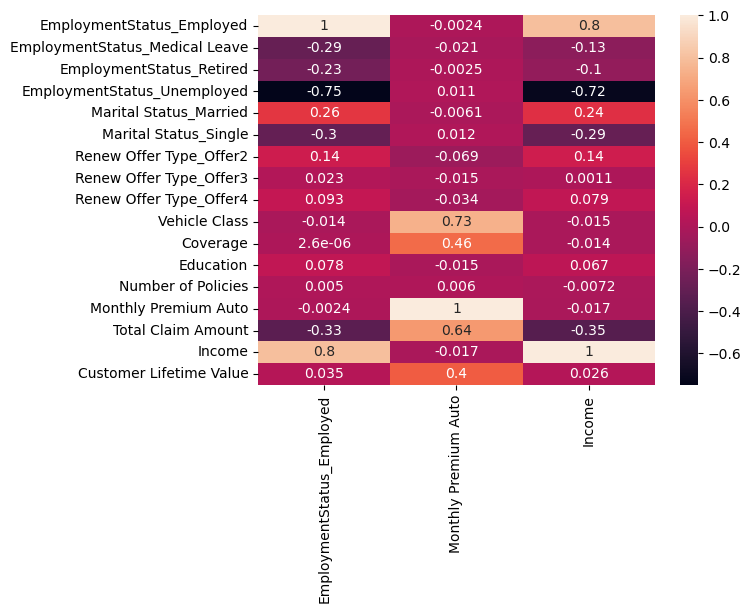

In [12]:
sns.heatmap(encoded_df.corr()[['EmploymentStatus_Employed', 'Monthly Premium Auto', 'Income']], annot=True)

- Employement status memiliki korelasi kuat (+/-) terhadap Income, maka dari itu, fitur employement status akan diremove dan berpatokan pada Income*
- Monthly Premium Auto berkorelasi kuat terhadap Vehicle Class & Total Claim.

*berdasarkan eda sebelumnya menjelaskan bahwa semua customer dengan status unemployed memiliki income = 0 <br>

**Handling MultiCollinearity**

In [11]:
# removed_cols = [x for x in encoded_df.columns if 'EmploymentStatus_' in x] + ['Vehicle Class', 'Total Claim Amount']
removed_cols = [x for x in encoded_df.columns if 'EmploymentStatus_' in x] + ['Monthly Premium Auto'] 

In [28]:
x_encoded_df.drop(columns=removed_cols, axis=1, inplace=True)

In [29]:
vif = pd.DataFrame()
vif['features'] = x_encoded_df.columns
vif['VIF'] = [variance_inflation_factor(x_encoded_df.values, i) for i in range(len(x_encoded_df.columns))]
vif

features       VIF
0    Marital Status_Married  3.697615
1     Marital Status_Single  2.211346
2   Renew Offer Type_Offer2  1.853266
3   Renew Offer Type_Offer3  1.375030
4   Renew Offer Type_Offer4  1.314563
5             Vehicle Class  2.169722
6                  Coverage  1.736195
7                 Education  2.153450
8        Number of Policies  2.334088
9        Total Claim Amount  4.646414
10                   Income  2.680203

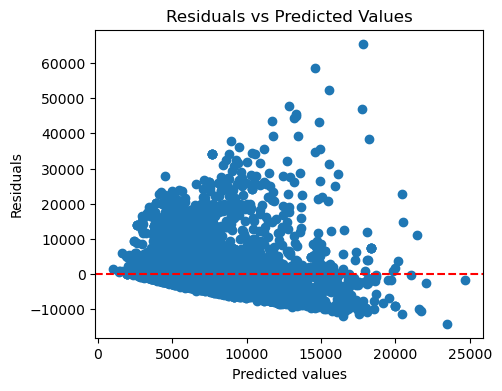

In [45]:
# X = sm.add_constant(x_encoded_df)
X = x_encoded_df
y = encoded_df['Customer Lifetime Value']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

plt.figure(figsize=(5,4))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

- Residual plot menunjukkan adanya kenaikan ataupun penurunan variance (heteroscedasticity). 
- Pada linear model heteroscedasticity dapat berdampak pada interpretasi model terhadap data, dimana asumsi data oleh linear model bersifat constant.

**Handling Heteroscedasticity**

In [46]:
scaled_encoded_df = x_encoded_df.copy()

In [47]:
scaler = RobustScaler()

In [48]:
scaled_encoded_df[['Total Claim Amount','Income']] = scaler.fit_transform(scaled_encoded_df[['Total Claim Amount','Income']])

In [49]:
# X = sm.add_constant(scaled_encoded_df)
X = scaled_encoded_df
y = encoded_df['Customer Lifetime Value']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Customer Lifetime Value   R-squared (uncentered):                   0.605
Model:                                 OLS   Adj. R-squared (uncentered):              0.604
Method:                      Least Squares   F-statistic:                              787.2
Date:                     Sun, 04 Aug 2024   Prob (F-statistic):                        0.00
Time:                             09:46:58   Log-Likelihood:                         -57955.
No. Observations:                     5669   AIC:                                  1.159e+05
Df Residuals:                         5658   BIC:                                  1.160e+05
Df Model:                               11                                                  
Covariance Type:                 nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Marital Status_Married   3080.0962    211.090     14.591      0.000    2666.279    3493.913
Marital Status_Single    3036.1776    236.181     12.855      0.000    2573.172    3499.183
Renew Offer Type_Offer2    32.8265    206.470      0.159      0.874    -371.935     437.588
Renew Offer Type_Offer3   505.7640    257.810      1.962      0.050       0.358    1011.170
Renew Offer Type_Offer4   210.7168    297.887      0.707      0.479    -373.256     794.689
Vehicle Class            1915.0341     80.063     23.919      0.000    1758.079    2071.989
Coverage                 2298.1469    140.609     16.344      0.000    2022.499    2573.795
Education                 631.7295     76.643      8.243      0.000     481.480     781.979
Number of Policies        324.3717     34.613      9.371      0.000     256.516     392.227
Total Claim Amount        241.3465    115.784      2.084      0.037      14.365     468.328
Income                    735.4781    205.149      3.585      0.000     333.307    1137.649
==============================================================================
Omnibus:                     3350.384   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35608.860
Skew:                           2.685   Prob(JB):                         0.00
Kurtosis:                      14.042   Cond. No.                         17.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hasil summary:
- R2 score model mencapai 60.5% merupakan nilai metrics pengukur kemampuan model dalam mengenali variance data. Masih ada kemungkinan untuk dilakukan improvement model.<br>
- p(F-stat) < 0.05, menunjukkan bahwa fitur yang dipakai (p=0, paling sedikit 1 atau beberapa) memiliki hubungan statistik secara significant terhadap target. <br>
- Skewness 2.685, p-val(JB) < 0.05 , menandakan distribusi residuals tidak normal. Terdapat outlier yang memungkinkan residual masih tergolong "bad residuals"   

**Scaled Feature**

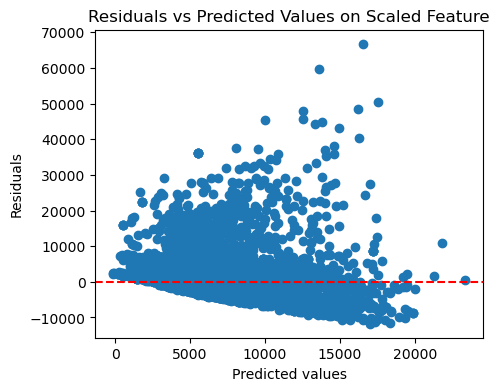

In [50]:
predictions = model.predict(X)
residuals = y - predictions

plt.figure(figsize=(5,4))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values on Scaled Feature')
plt.axhline(0, color='red', linestyle='--')
plt.show()

**Weighted Least Square**

Teknik untuk meminimalkan variance dari residuals.

*inverse of the variance of the residuals

In [51]:
# https://online.stat.psu.edu/stat501/lesson/13/13.1
wt = 1 / (model.resid**2)

In [52]:
wls = sm.WLS(y, X, weights=wt).fit()
wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   WLS Regression Results                                   
============================================================================================
Dep. Variable:     Customer Lifetime Value   R-squared (uncentered):                   1.000
Model:                                 WLS   Adj. R-squared (uncentered):              1.000
Method:                      Least Squares   F-statistic:                          4.702e+07
Date:                     Sun, 04 Aug 2024   Prob (F-statistic):                        0.00
Time:                             10:09:39   Log-Likelihood:                         -52028.
No. Observations:                     5669   AIC:                                  1.041e+05
Df Residuals:                         5658   BIC:                                  1.042e+05
Df Model:                               11                                                  
Covariance Type:                 nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Marital Status_Married   3064.1720      6.814    449.673      0.000    3050.814    3077.530
Marital Status_Single    3027.7693      4.961    610.359      0.000    3018.045    3037.494
Renew Offer Type_Offer2    34.8314      4.829      7.212      0.000      25.364      44.299
Renew Offer Type_Offer3   513.8158     11.735     43.784      0.000     490.810     536.821
Renew Offer Type_Offer4   218.9608      4.382     49.966      0.000     210.370     227.552
Vehicle Class            1914.9010      1.001   1912.061      0.000    1912.938    1916.864
Coverage                 2284.9711      4.341    526.388      0.000    2276.461    2293.481
Education                 634.9210      2.158    294.272      0.000     630.691     639.151
Number of Policies        325.4401      1.141    285.198      0.000     323.203     327.677
Total Claim Amount        237.3712      3.623     65.510      0.000     230.268     244.475
Income                    740.4110      3.904    189.674      0.000     732.758     748.064
==============================================================================
Omnibus:                    26303.528   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              962.611
Skew:                           0.573   Prob(JB):                    9.37e-210
Kurtosis:                       1.338   Cond. No.                         153.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Setelah melakukan optimasi variance, r2 score meningkat sangat significant*
- Namun, uji test Prob JB < 0.05, Skew 0.57 menjelaskan bahwa residu masih tidak terdistribusi secara normal*.

*Concern indikasi overfitting / heteroscedasticity

In [53]:
wls_pred = wls.predict(X)

In [54]:
wls_error = pd.concat([pd.DataFrame(y), pd.DataFrame(wls_pred, columns=['pred'])], axis=1)
wls_error['error'] = np.abs(wls_error['Customer Lifetime Value']-wls_error['pred'])
wls_error['percentage_error'] = wls_error['error']*100/wls_error['Customer Lifetime Value']
f"Rata persentase error: {round(np.median(wls_error['percentage_error']),2)}%"

'Rata persentase error: 45.76%'

In [55]:
residuals = y - wls_pred

plt.figure(figsize=(5,4))
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values on WLS')
plt.axhline(0, color='red', linestyle='--')
plt.show()

Karena heteroscedasticity, beberapa alternatif yang bisa dilakukan:
- Mengecek penyebab variansi residual tidak konstan*.
- Menggunakan alternative model (Next)

*analisis robust standard error

**Model yang akan diuji:**
- Random Forest: Ensemble method dimana cara kerja membentuk beberapa decision tree dan mengkombinasikan hasil prediksi dari rata masing-masing decision tree tersebut, less sensitive terhadap outlier. 
- Gradient Boosting Machines: sequential training pada cara kerja model memungkinkan model dalam meminimalisir error.

In [57]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [58]:
models = ['RandomForestRegressor', 'GradientBoostingRegressor']

Metrics utama yang dipakai:
- MedAE: Nilai *rata error dari hasil prediksi dalam skala unit.
- MedAPE**: Nilai *rata error dari hasil prediksi dalam skala persen. 
- R2 Score: Mengukur kemampuan dalam mengenali varians data terhadap target

Metrics tambahan:
- RMSE: Identifikasi besaran outlier pada error dalam skala unit.
- MAPE: Identifikasi besaran outlier pada error dalam skala persen.

*median <br>
**menggunakan formula: abs(y_pred - y_true)/y_true

In [59]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer

#### Data Splitting

In [60]:
df_train, df_test = train_test_split(encoded_df, test_size=0.2, random_state=42)

In [62]:
X_train = df_train.drop(columns=['Customer Lifetime Value'], axis=1)
X_test = df_test.drop(columns=['Customer Lifetime Value'], axis=1)
y_train = df_train['Customer Lifetime Value']
y_test = df_test['Customer Lifetime Value']

#### Original Feature

RandomForest & GBM merupakan tree-based model yang melakukan pembagian data berdasarkan range nilai fitur tertentu, sehingga scaling fitur tidak berpengaruh.

In [63]:
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()

In [64]:
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)

GradientBoostingRegressor()

##### **Train Evaluation**

In [65]:
rf_pred = rf.predict(X_train)
gbm_pred = gbm.predict(X_train)

In [66]:
error_summaries = {}

for i in models:
    error_summary = pd.DataFrame
    if i == 'RandomForestRegressor':
        error_summary = pd.concat([pd.DataFrame(y_train.reset_index(drop=True)), pd.DataFrame(rf_pred, columns=['pred'])], axis=1)
    elif i == 'GradientBoostingRegressor':
        error_summary = pd.concat([pd.DataFrame(y_train.reset_index(drop=True)), pd.DataFrame(gbm_pred, columns=['pred'])], axis=1)

    error_summary.rename(columns={'Customer Lifetime Value':'train_clv'}, inplace=True)
    error_summary['error'] = np.abs(error_summary['train_clv'] - error_summary['pred'])
    error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['train_clv'],2)
    error_summaries[i] = error_summary

In [67]:
plt.figure(figsize=(8, 4))
for k, v in enumerate(models):
    plt.subplot(1, len(models), k+1)
    plt.scatter(x=error_summaries[v]['train_clv'], y=error_summaries[v]['pred'])
    plt.title(v)
    plt.xlabel('true')
    plt.ylabel('prediction')
plt.suptitle('Model Prediction Plots: Train')
plt.tight_layout()

- Random Forest Regressor dapat memprediksi data train dengan baik dibandingkan Gradient Boosting.

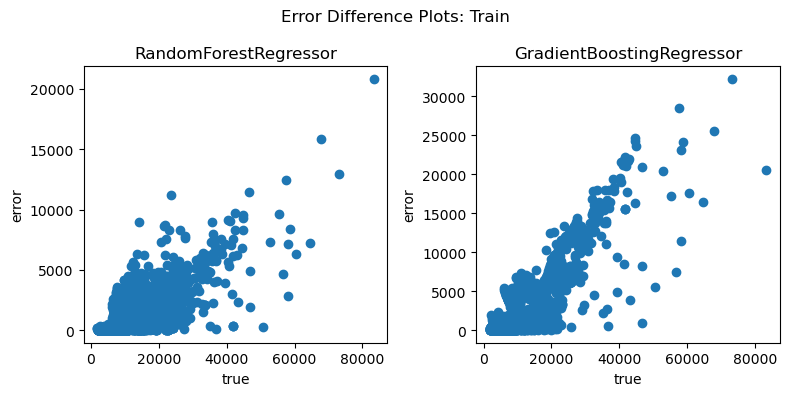

In [68]:
plt.figure(figsize=(8, 4))
for k, v in enumerate(models):
    plt.subplot(1, len(models), k+1)
    plt.scatter(x=error_summaries[v]['train_clv'], y=error_summaries[v]['error'])
    plt.title(v)
    plt.xlabel('true')
    plt.ylabel('error')
plt.suptitle('Error Difference Plots: Train')
plt.tight_layout()

- Error difference plot Random Forest lebih baik dibanding Gradient Boosting
- Error difference pada Gradient Boosting terlalu jauh terhadap nilai aktual.

In [69]:
error_results = {}
r2_score, medae, mape, rmse = 0,0,0,0
for i in models:
    if i == 'RandomForestRegressor':
        r2_score = rf.score(X_train, y_train)
        medae = median_absolute_error(y_train, rf_pred)
        rmse = mean_squared_error(y_train, rf_pred, squared=False)
        mape = mean_absolute_percentage_error(y_train, rf_pred)
    elif i == 'GradientBoostingRegressor':
        r2_score = gbm.score(X_train, y_train)
        medae = median_absolute_error(y_train, gbm_pred)
        rmse = mean_squared_error(y_train, gbm_pred, squared=False)
        mape = mean_absolute_percentage_error(y_train, gbm_pred)

    error_results[i] = {}
    error_results[i]['R2_Score'] = r2_score
    error_results[i]['MedAE'] = medae
    error_results[i]['MedAPE'] = np.median(error_summaries[i]['error_percentage'])
    error_results[i]['RMSE'] = rmse
    error_results[i]['MAPE'] = mape*100

In [70]:
train_result = pd.DataFrame(error_results)
train_result

RandomForestRegressor  GradientBoostingRegressor
R2_Score               0.957560                   0.748371
MedAE                 30.165942                 274.613553
MedAPE                 0.600000                   5.630000
RMSE                1437.887935                3501.222850
MAPE                   3.983755                  13.359825

Hasil evaluasi metric pada data train:
- Random Forest Regressor mampu mengenali varians data train sangat baik (R2 Score = 95%), diikuti dengan, 
- Gradient Boosting bisa dikatakan masih cukup mampu mengenali varians data train (R2 Score = 75%)

Error Percentage:
- Selisih error paling minim berada pada model RandomForestRegressor dengan rata error 0.6% (MedAPE) dengan MAPE 3.9% (jarak outlier error tidak sejauh pada GBM yang mencapai 13%)

##### **Test Evaluation**

In [71]:
rf_pred = rf.predict(X_test)
gbm_pred = gbm.predict(X_test)

In [72]:
error_summaries = {}

for i in models:
    error_summary = pd.DataFrame
    if i == 'RandomForestRegressor':
        error_summary = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)), pd.DataFrame(rf_pred, columns=['pred'])], axis=1)
    elif i == 'GradientBoostingRegressor':
        error_summary = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)), pd.DataFrame(gbm_pred, columns=['pred'])], axis=1)

    error_summary.rename(columns={'Customer Lifetime Value':'test_clv'}, inplace=True)
    error_summary['error'] = np.abs(error_summary['test_clv'] - error_summary['pred'])
    error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['test_clv'],2)
    error_summaries[i] = error_summary

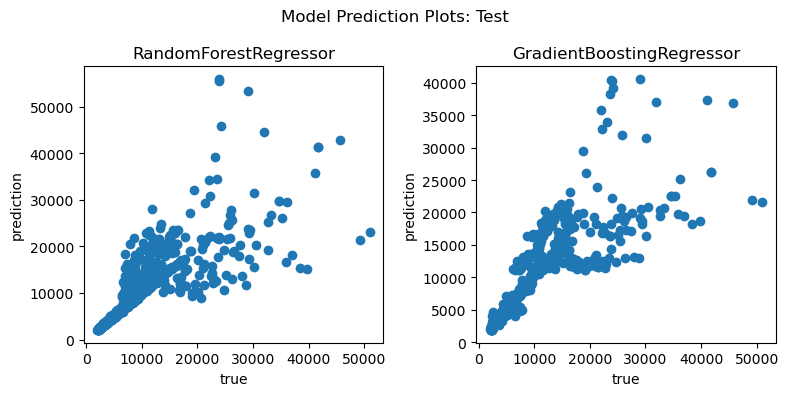

In [73]:
plt.figure(figsize=(8, 4))
for k, v in enumerate(models):
    plt.subplot(1, len(models), k+1)
    plt.scatter(x=error_summaries[v]['test_clv'], y=error_summaries[v]['pred'])
    plt.title(v)
    plt.xlabel('true')
    plt.ylabel('prediction')
plt.suptitle('Model Prediction Plots: Test')
plt.tight_layout()

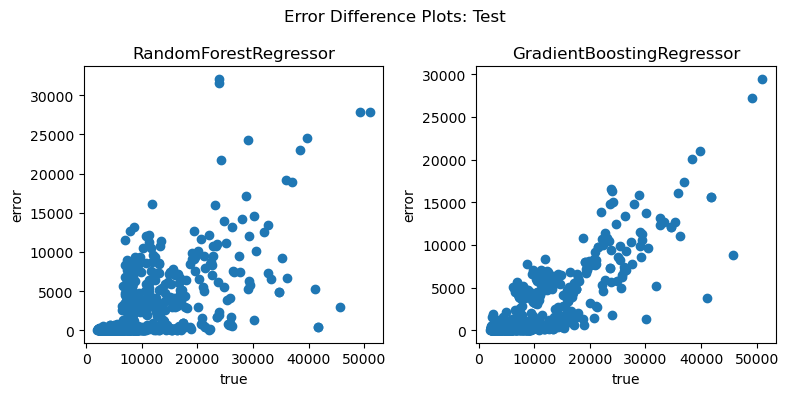

In [74]:
plt.figure(figsize=(8, 4))
for k, v in enumerate(models):
    plt.subplot(1, len(models), k+1)
    plt.scatter(x=error_summaries[v]['test_clv'], y=error_summaries[v]['error'])
    plt.title(v)
    plt.xlabel('true')
    plt.ylabel('error')
plt.suptitle('Error Difference Plots: Test')
plt.tight_layout()

In [75]:
error_results = {}
r2_score, medae, mape, rmse = 0,0,0,0
for i in models:
    if i == 'RandomForestRegressor':
        r2_score = rf.score(X_test, y_test)
        medae = median_absolute_error(y_test, rf_pred)
        rmse = mean_squared_error(y_test, rf_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, rf_pred)
    elif i == 'GradientBoostingRegressor':
        r2_score = gbm.score(X_test, y_test)
        medae = median_absolute_error(y_test, gbm_pred)
        rmse = mean_squared_error(y_test, gbm_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, gbm_pred)

    error_results[i] = {}
    error_results[i]['R2_Score'] = r2_score
    error_results[i]['MedAE'] = medae
    error_results[i]['MedAPE'] = np.median(error_summaries[i]['error_percentage'])
    error_results[i]['RMSE'] = rmse
    error_results[i]['MAPE'] = mape*100

In [76]:
test_result = pd.DataFrame(error_results)

In [77]:
pd.concat([train_result, test_result], axis=1, keys=['train', 'test'])

train                            \
         RandomForestRegressor GradientBoostingRegressor   
R2_Score              0.957560                  0.748371   
MedAE                30.165942                274.613553   
MedAPE                0.600000                  5.630000   
RMSE               1437.887935               3501.222850   
MAPE                  3.983755                 13.359825   

                          test                            
         RandomForestRegressor GradientBoostingRegressor  
R2_Score              0.653362                  0.694867  
MedAE                90.685784                297.639804  
MedAPE                1.695000                  6.220000  
RMSE               3918.246716               3676.187833  
MAPE                 12.217382                 15.493699

Test Result:
- Hasil Metrics pada testing set tidak sebaik pada saat uji training, indikasi `overfitting`.
- Gradient Boosting: High R2 & Low RMSE (dibandingkan Random Forest) menjelaskan bahwa model lebih baik dalam mengenali varians data.
- Random Forest: Low MedAE, MedAPE, MAPE menjelaskan akurasi model dalam menentukan nilai CLV. Semakin kecil selisih error menandakan kemampuan model dalam menentukan nilai CLV lebih baik.

R2 Score pada kedua model tidak terlalu significant.<br>
Pada case ini dengan dataset yang tersedia maka error percentage pada CLV score lebih diutamakan (next improvement: Random Forest)<br>

##### **Estimator Evaluation: Cross Validation - Tuning**

Mencari best parameter untuk mengatasi Overfitting.


In [78]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [79]:
trees = rf.estimators_
depths = [tree.get_depth() for tree in trees]

In [80]:
rf_summary = {
    "n_estimators": len(trees),
    "min_depth":np.min(depths),
    "max_depth":np.max(depths),
    "avg_depth":np.mean(depths),
}
rf_summary

{'n_estimators': 100, 'min_depth': 21, 'max_depth': 32, 'avg_depth': 24.23}

In [85]:
# rf = RandomForestRegressor()

In [89]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_cv = GridSearchCV(
    estimator=rf,
    param_grid={
        'n_estimators': [150, 200, 250],
        'max_depth': [22, 24, 31],
        'min_samples_leaf':[5, 10, 15],
    },
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=kf,
    verbose=0
)

In [90]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [22, 24, 31],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [150, 200, 250]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [91]:
print(f"Best Params : {grid_cv.best_params_}")
print(f"Best Score : {grid_cv.best_score_}")

Best Params : {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 150}
Best Score : -0.11223971773467208


**Refit with Tuned Model**

In [92]:
tuned_model = grid_cv.best_estimator_

In [93]:
tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=22, min_samples_leaf=5, n_estimators=150)

In [94]:
tuned_y_pred = tuned_model.predict(X_test)

In [95]:
error_summaries = {}

error_summary = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)), pd.DataFrame(tuned_y_pred, columns=['pred'])], axis=1)
error_summary.rename(columns={'Customer Lifetime Value':'test_clv'}, inplace=True)
error_summary['error'] = np.abs(error_summary['test_clv'] - error_summary['pred'])
error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['test_clv'],2)
error_summaries['RandomForestRegressor'] = error_summary  

In [96]:
error_results = {}
error_results['RandomForestRegressor'] = {}
error_results['RandomForestRegressor']['R2_Score'] = tuned_model.score(X_test, y_test)
error_results['RandomForestRegressor']['MedAE'] = median_absolute_error(y_test, tuned_y_pred)
error_results['RandomForestRegressor']['MedAPE'] = np.median(error_summaries['RandomForestRegressor']['error_percentage'])
error_results['RandomForestRegressor']['RMSE'] = mean_squared_error(y_test, tuned_y_pred, squared=False)
error_results['RandomForestRegressor']['MAPE'] = (mean_absolute_percentage_error(y_test, tuned_y_pred))*100

In [ ]:
tuned_test_result = pd.DataFrame(error_results)

In [98]:
pd.concat([test_result['RandomForestRegressor'], tuned_test_result], axis=1, keys=['default test', 'tuning test'])

default test           tuning test
         RandomForestRegressor RandomForestRegressor
R2_Score              0.653362              0.676434
MedAE                90.685784             97.710257
MedAPE                1.695000              1.915000
RMSE               3918.246716           3785.601966
MAPE                 12.217382             12.454736

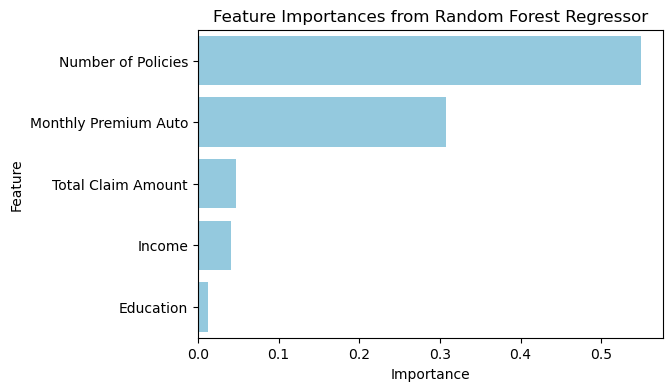

In [99]:
importance_df = pd.DataFrame({
    'Feature': encoded_df.drop(columns=['Customer Lifetime Value'], axis=1).columns,
    'Importance': tuned_model.feature_importances_
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.nlargest(5, columns=['Importance']), color='skyblue')
plt.title('Feature Importances from Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [100]:
feature_names = importance_df.nlargest(5, columns=['Importance'])['Feature'].values

In [101]:
selected_x_train = X_train[feature_names]
selected_x_test = X_test[feature_names]

In [102]:
tuned_model.fit(selected_x_train, y_train)

RandomForestRegressor(max_depth=22, min_samples_leaf=5, n_estimators=150)

In [103]:
selected_tuned_y_pred = tuned_model.predict(selected_x_test)

In [105]:
error_summaries = {}

error_summary = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)), pd.DataFrame(selected_tuned_y_pred, columns=['pred'])], axis=1)
error_summary.rename(columns={'Customer Lifetime Value':'test_clv'}, inplace=True)
error_summary['error'] = np.abs(error_summary['test_clv'] - error_summary['pred'])
error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['test_clv'],2)
error_summaries['RandomForestRegressor'] = error_summary  

In [106]:
error_results = {}
error_results['RandomForestRegressor'] = {}
error_results['RandomForestRegressor']['R2_Score'] = tuned_model.score(selected_x_test, y_test)
error_results['RandomForestRegressor']['MedAE'] = median_absolute_error(y_test, selected_tuned_y_pred)
error_results['RandomForestRegressor']['MedAPE'] = np.median(error_summaries['RandomForestRegressor']['error_percentage'])
error_results['RandomForestRegressor']['RMSE'] = mean_squared_error(y_test, selected_tuned_y_pred, squared=False)
error_results['RandomForestRegressor']['MAPE'] = (mean_absolute_percentage_error(y_test, selected_tuned_y_pred))*100

In [107]:
selected_tuned_test_result = pd.DataFrame(error_results)

In [108]:
pd.concat([tuned_test_result['RandomForestRegressor'], selected_tuned_test_result], axis=1, keys=['overall test', 'selected test'])

overall test         selected test
         RandomForestRegressor RandomForestRegressor
MAPE                 12.454736             12.675197
MedAE                97.710257            116.870120
MedAPE                1.915000              2.330000
R2_Score              0.676434              0.681185
RMSE               3785.601966           3757.707391

- Hasil pemilihan top feature penurunan residu tidak terlalu signifikan, hanya peningkatan R2 menjadi 68% dan penurunan besaran error RMSE sekitar <>20 poin dalam satuan unit.

**Manual Approach**

Pendekatan yang dilakukan dengan mencari data yang dapat dipahami oleh model dari *keseluruhan dataset* menggunakan cross validation dan model yang sudah dituning.

In [109]:
tuned_model

RandomForestRegressor(max_depth=22, min_samples_leaf=5, n_estimators=150)

In [110]:
# print(cross_val_score(tuned_model, X_train, y_train, cv=kf, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)))

[-0.1100002  -0.10648069 -0.11544485 -0.11037535 -0.11980434]


In [113]:
X = encoded_df.drop(columns=['Customer Lifetime Value'], axis=1)
y = encoded_df['Customer Lifetime Value']

In [114]:
print(cross_val_score(tuned_model, X, y, cv=kf, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)))

[-0.12458635 -0.10278512 -0.10469705 -0.10778598 -0.11560176]


- MAPE terendah berada pada fold ke-2

In [115]:
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    if fold == 2:
        global X_train_fold, X_val_fold, y_train_fold, y_val_fold
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        break

In [116]:
tuned_model.fit(X_train_fold, y_train_fold)

RandomForestRegressor(max_depth=22, min_samples_leaf=5, n_estimators=150)

In [117]:
manual_tuning_y_pred = tuned_model.predict(X_val_fold)

In [118]:
error_summaries = {}

error_summary = pd.concat([pd.DataFrame(y_val_fold.reset_index(drop=True)), pd.DataFrame(manual_tuning_y_pred, columns=['pred'])], axis=1)
error_summary.rename(columns={'Customer Lifetime Value':'test_clv'}, inplace=True)
error_summary['error'] = np.abs(error_summary['test_clv'] - error_summary['pred'])
error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['test_clv'],2)
error_summaries['RandomForestRegressor'] = error_summary  

In [119]:
error_results = {}
error_results['RandomForestRegressor'] = {}
error_results['RandomForestRegressor']['R2_Score'] = tuned_model.score(X_val_fold, y_val_fold)
error_results['RandomForestRegressor']['MedAE'] = median_absolute_error(y_val_fold, manual_tuning_y_pred)
error_results['RandomForestRegressor']['MedAPE'] = np.median(error_summaries['RandomForestRegressor']['error_percentage'])
error_results['RandomForestRegressor']['RMSE'] = mean_squared_error(y_val_fold, manual_tuning_y_pred, squared=False)
error_results['RandomForestRegressor']['MAPE'] = (mean_absolute_percentage_error(y_val_fold, manual_tuning_y_pred))*100

In [120]:
manual_tuning_test_result = pd.DataFrame(error_results)

In [121]:
pd.concat([tuned_test_result['RandomForestRegressor'], manual_tuning_test_result], axis=1, keys=['original test', 'crossval split test'])

original test   crossval split test
         RandomForestRegressor RandomForestRegressor
MAPE                 12.454736             10.533506
MedAE                97.710257             84.243475
MedAPE                1.915000              1.750000
R2_Score              0.676434              0.684476
RMSE               3785.601966           3899.649093

- Penerapan Manual Approach berhasil meminimalisir error outlier sebesar 2% (MAPE), meminimalisir error rate dari 1.91% -> 1.75% (MedAPE) dan meningkatkan kemampuan model dalam mengenali variansi data sebesar 1% (R2 Score).

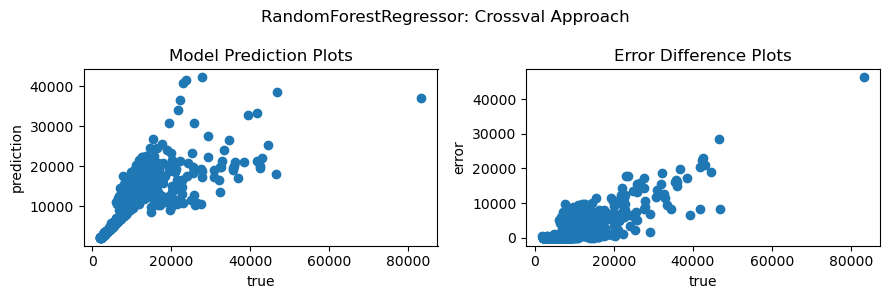

In [123]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.scatter(x=error_summaries['RandomForestRegressor']['test_clv'], y=error_summaries['RandomForestRegressor']['pred'])
plt.title('Model Prediction Plots')
plt.xlabel('true')
plt.ylabel('prediction')

plt.subplot(1, 2, 2)
plt.scatter(x=error_summaries['RandomForestRegressor']['test_clv'], y=error_summaries['RandomForestRegressor']['error'])
plt.title('Error Difference Plots')
plt.xlabel('true')
plt.ylabel('error')

plt.suptitle('RandomForestRegressor: Crossval Approach')
plt.tight_layout()

In [137]:
train_manual_tuning_y_pred = tuned_model.predict(X_train_fold)

In [138]:
error_summaries = {}

error_summary = pd.concat([pd.DataFrame(y_train_fold.reset_index(drop=True)), pd.DataFrame(train_manual_tuning_y_pred, columns=['pred'])], axis=1)
error_summary.rename(columns={'Customer Lifetime Value':'train_clv'}, inplace=True)
error_summary['error'] = np.abs(error_summary['train_clv'] - error_summary['pred'])
error_summary['error_percentage'] = round(error_summary['error']*100/error_summary['train_clv'],2)
error_summaries['RandomForestRegressor'] = error_summary  

In [139]:
error_results = {}
error_results['RandomForestRegressor'] = {}
error_results['RandomForestRegressor']['R2_Score'] = tuned_model.score(X_train_fold, y_train_fold)
error_results['RandomForestRegressor']['MedAE'] = median_absolute_error(y_train_fold, train_manual_tuning_y_pred)
error_results['RandomForestRegressor']['MedAPE'] = np.median(error_summaries['RandomForestRegressor']['error_percentage'])
error_results['RandomForestRegressor']['RMSE'] = mean_squared_error(y_train_fold, train_manual_tuning_y_pred, squared=False)
error_results['RandomForestRegressor']['MAPE'] = (mean_absolute_percentage_error(y_train_fold, train_manual_tuning_y_pred))*100

In [140]:
manual_tuning_train_result = pd.DataFrame(error_results)

In [141]:
manual_tuning_train_result

RandomForestRegressor
MAPE                   8.050744
MedAE                 68.781083
MedAPE                 1.340000
R2_Score               0.842163
RMSE                2744.801103

In [144]:
cv_importance_df = pd.DataFrame({
    'Feature': encoded_df.drop(columns=['Customer Lifetime Value'], axis=1).columns,
    'Importance': tuned_model.feature_importances_
})

cv_importance_df = cv_importance_df.sort_values(by='Importance', ascending=False)
cv_importance_df[:5]

Feature  Importance
12    Number of Policies    0.552865
13  Monthly Premium Auto    0.300878
14    Total Claim Amount    0.047337
15                Income    0.040562
11             Education    0.014554

In [136]:
import pickle

estimator = Pipeline([('preprocess', preprocessor), ('model', tuned_model)])
estimator.fit(
    df.iloc[X_train_fold.index].drop(columns=['Customer Lifetime Value'], axis=1), 
    df.iloc[X_train_fold.index]['Customer Lifetime Value']
)

with open("random_forest_tuned_model.pkl", "wb") as f:
    pickle.dump(estimator, f)

**Summary**<br>
Batasan pada analisis mencari best approach untuk meningkatkan performa model dan diperoleh:<br>
Hasil test pada pendekatan crossval ketika proses splitting mampu meningkatkan performa model, 68% pada r2 score mengindikasi model saat ini mampu mengenali 68% variansi data dalam menentukan nilai target cukup baik. Namun masih terdapat concern overfitting (R2 train=84%).
Pada next analysis, beberapa yang perlu dilakukan:
1. Melakukan analisis error yang menyebabkan error tinggi.
2. Melakukan analisis terhadap dataset yang menjadi penyebab error tinggi, *memastikan consistency data*.
3. Jika data masih terlalu complex, lakukan re-tuning dengan nilai berbeda dari yang telah dilakukan terutama pada kedalam tree ataupun n_estimator bisa mencegah model mempelajari terlalu dalam.
<br>

Berikut rekomendasi yang disarankan untuk analisis selanjutnya:
1. Dilihat dari feature importance, hanya ada 2 yang paling significant yaitu Number of Policies dan Monthly Premium Auto, oleh karena itu disarankan untuk melakukan penambahan fitur dengan tujuan agar pemilihan fitur yang sesuai dapat lebih luas.